### Importing modules

In [1]:
import os
import pandas as pd 
import numpy as np; np.random.seed(25486)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co
import warnings; warnings.filterwarnings('ignore')
import pickle
import json
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.utils

le = sklearn.preprocessing.LabelEncoder
regressors = dict(sklearn.utils.all_estimators('regressor'))
metrics = sklearn.metrics._regression
mae = metrics.mean_absolute_error
mse = metrics.mean_squared_error
mape = metrics.mean_absolute_percentage_error
r2 = metrics.r2_score
me = metrics.max_error
medae = metrics.median_absolute_error
evs = metrics.explained_variance_score
mpd = metrics.mean_poisson_deviance
mgd = metrics.mean_gamma_deviance

def wape(ye, yhat):
    return np.abs(ye-yhat).sum()/ye.sum()
def e(ye, yhat):
    return np.abs(yhat-ye).sum()
def estd(ye, yhat):
    return np.abs(yhat-ye).std()

In [2]:
import tools # Custom model

### Declarando Funções

In [7]:
# class ts_model_selection:
#     def __init__(self):
#         self.description='python class for univariate or multivariate time series modeling methods'

## Evaluating Model Predictions
def score_predictions(y_e, y_hat):
    return [mae(y_e, y_hat), mse(y_e, y_hat), mape(y_e, y_hat), wape(y_e, y_hat), r2(y_e, y_hat)]

## Evaluating model predictions given scorer list
def score_predictions_custom(y_e, y_hat, scorers=None):
    if type(scorers)==type(None):
        scorers = [mae, mse, mape, wape, r2]; names=['mae', 'mse', 'mape', 'wape', 'r2']
    return [scorer(y_e, y_hat) for scorer in scorers]

def score_by_product(Y_e, Y_hat, indexes, model_name, key='product_type', scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2']):
    prod_scrs = []
    for product in indexes.keys():
        prod_index = indexes[product]
        prod_scrs.append([ product ] + score_predictions_custom(Y_e.loc[prod_index], Y_hat.loc[prod_index], scorers=scorers))
    prod_scrs = pd.DataFrame(prod_scrs, columns=[key]+scorers_names)
    return prod_scrs

def score_model_predictions(Y_hat, Y_e, indexes, model_name, by='product_type', scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2']):
    model_scrs = pd.Series(score_predictions_custom(Y_e, Y_hat, scorers=scorers), index=scorers_names).to_frame().rename(columns={0: model_name}).T;
    prod_scrs = score_by_product(Y_e, Y_hat, indexes, model_name, key=by, scorers=scorers, scorers_names=scorers_names)
    return model_scrs, prod_scrs

## Fit and retrieve score by model and time serie
def split_fit_predict_score_ts(df, key, data, model, model_name, scorers=None, x_cols=['year']):
    x_t, x_e, y_t, y_e = tools.preprocess().custom_tts(df, data, x_cols=x_cols)
    model.fit(x_t, y_t)
    y_hat = model.predict(x_e)
    info = [key, model_name]
    scrs = info + score_predictions_custom(y_e, y_hat, scorers=scorers)
    return scrs, model, pd.Series(y_hat, index=y_e.index, name=model_name)

# def concat_prediction_arrays_dict(predictions, keys=None, model_name=''):
#     Y_hat = []
#     if keys is None:  keys = predictions.keys()
#     for key in keys:
#         Y_hat.append(pd.Series(predictions[key]))
#     Y_hat = pd.concat(Y_hat)
#     Y_hat.index = Y_e.index
#     Y_hat.index.name = 'Index'
#     return Y_hat

def split_fit_predict_score_ts_dict(series, model, model_name='', keys=None, verbose=1, scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2'], x_cols=['year']):
    model_scrs, models, predictions = [], {}, []
    if keys is None: keys = list(series.keys())
    n, cnt = len(keys), 0; frames = range(0, n, 20)
    for key in keys:
        cnt+=1;
        if verbose==1:
            if cnt in frames:
                co(wait=True); print(f'{cnt}/{n}')
        scores, model, y_hat = split_fit_predict_score_ts(series[key], key, data, model, model_name, scorers, x_cols=x_cols)
        model_scrs.append(scores)
        models[key] = model
        y_hat.index.name='Index'
        predictions.append(y_hat)
    scrs_df = pd.DataFrame(model_scrs, columns=['city-product', 'model'] + scorers_names)
    Y_hat = pd.concat(predictions)
#     Y_hat = concat_prediction_arrays_dict(predictions, keys, model_name)
    return scrs_df, models, Y_hat

def model_ts_dict_regressors_grid(series, Y_e, choosen_models, score_indexes, keys=None, x_cols=['year'], scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2'], save_models=False, save_scores=False, save_predictions=False):
    failed_models = []
    ts_models_scrs, fitted_model_groups, models_scrs = [], [], []
    models_prod_scrs, models_prediction = [], []
    if keys is None: keys = list(series.keys())
    cnt, n = 0, len(choosen_models)
    for model_name in choosen_models:
        cnt+=1
        co(wait=True); print(f'{cnt}/{n} - Scoring model {model_name}')
        model = regressors[model_name]()
        ts_scrs, fitted_models, Y_hat = split_fit_predict_score_ts_dict(series, model, model_name, keys=keys, verbose=0, scorers=scorers, scorers_names=scorers_names, x_cols=x_cols)
        model_scrs, prod_scrs = score_model_predictions(Y_hat, Y_e, score_indexes, model_name, by='product_type', scorers=scorers, scorers_names=scorers_names)
        model_scrs['model'] = model_name
        prod_scrs['model'] = model_name
        ts_models_scrs.append(ts_scrs)
        fitted_model_groups.append(fitted_models)
        models_scrs.append(model_scrs)
        models_prod_scrs.append(prod_scrs)
        models_prediction.append(Y_hat)

    choosen_models = [name for name in choosen_models if name not in failed_models]
    ts_models_scrs = pd.concat(ts_models_scrs, 0).reset_index(drop=True)
    models_scrs = pd.concat(models_scrs, 0).reset_index(drop=True).set_index('model')
    models_prod_scrs = pd.concat(models_prod_scrs, 0).reset_index(drop=True)
    models_prediction = pd.concat(models_prediction, 1); #models_prediction.columns = choosen_models

    #### Saving models scores
    if save_scores:
        ts_models_scrs.to_csv('evaluation/scores_timeseries_regressors.csv', index=True)
        models_scrs.to_csv('evaluation/scores_regressors.csv', index=True)
        models_prod_scrs.to_csv('evaluation/product_scores_regressors.csv', index=True)

    if save_predictions:
        models_prediction.to_csv('evaluation/models_prediction.csv', index=True)

    #### Saving fitted regressors
    if save_models:
        cnt, n = 0, len(choosen_models)*len(series.keys())
        for model_group, model_name in zip(fitted_model_groups, choosen_models):
            for key in model_group.keys():
                pickle.dump(model_group[key], open('models/regressors/'+model_name+'_'+key+'.sav', 'wb'))
                cnt+=1
                if cnt%5==0: co(wait=True); print(f'{cnt}/{n} models saved.')

    return ts_models_scrs, models_scrs, models_prod_scrs, models_prediction

#### Reloading models scores and predictions
def load_scrs_preds(path='evaluation/{}'):
    ts_models_scrs = pd.read_csv(path.format('scores_timeseries_regressors.csv'), index_col=0)
    models_scrs = pd.read_csv(path.format('scores_regressors.csv'), index_col=0)
    models_prod_scrs = pd.read_csv(path.format('product_scores_regressors.csv'), index_col=0)
    models_prediction = pd.read_csv(path.format('models_prediction.csv'), index_col=0)
    return ts_models_scrs, models_scrs, models_prod_scrs, models_prediction

def load_ts_model(key, path='models/regressors/'):    
    return pickle.load(open(f'{path}{key}.sav', 'rb'))

def load_regressors(path='models/regressors/'):
    filenames = os.listdir(path)
    regs, cnt, n_files = {}, 0, len(filenames)
    freq = range(1, n_files, 10)
    for filename in filenames:
        cnt+=1
        if cnt in freq: print(f'Files loaded: {cnt}/{n_files}'); co(wait=True)
        regs[filename[:-4]] = pickle.load(open(path+filename, 'rb'))
    print(f'Done! Loaded {n_files} files.')
    return regs

def models_scr_heatmap(df, width=12):    
    fig = plt.figure(figsize=(12.5/5*len(df.columns), 8.5/33*len(df)), tight_layout=True)
    axes = fig.subplots(1, len(df.columns), sharey=False)
    for col, ax in zip(df, axes):
        sns.heatmap(df[[col]], annot=True, ax=ax)
        if col!=df.columns[0]: ax.set(ylabel='', yticks=[])
    plt.show()

def index_and_score_predictions(series, Yhat_ext, target, target_years):
    models_names = Yhat_ext.drop(['key', 'year'], 1).columns
    ts_models_scrs, models_predictions = [], []
    cnt1 = 0
    for model_name in models_names:
        cnt2 = 0; cnt1+=1
        model_prediction = []
        for key in keys:
            cnt2+=1
            if cnt2%5==0: co(wait=True); print(f'{cnt1}/{len(models_names)} - {cnt2}/{len(keys)}  (Models - Series)')
            model_key_yhat = Yhat_ext.set_index('key').loc[key].set_index('year').sort_index()[model_name]
            serie = series[key]
            y_test = serie[serie['year'].isin(target_years)].sort_values('year')[[target, 'year']].copy()
            yhat_i = model_key_yhat.loc[y_test['year']]
            yhat_i.index = y_test.index
            key_model_scrs = [key, model_name] + score_predictions_custom(y_test[target], yhat_i.fillna(0), scorers=scorers)
            model_prediction.append(yhat_i)
            ts_models_scrs.append(key_model_scrs)
        model_prediction = pd.concat(model_prediction, 0)
        model_prediction.name = model_name
        models_predictions.append(model_prediction)
    specialized_prediction = pd.concat(models_predictions, 1)
    ts_specialized_scrs = pd.DataFrame(ts_models_scrs, columns=['city-product', 'model'] + scorers_names)
    return specialized_prediction, ts_specialized_scrs

# Returns a dict with series keys as keys and model names as values (maps each series to a model based on a criteria metric)
def top_models_per_ts(ts_models_scrs, criteria, criteria_map):
    top_models_by_scr = {}
    for key in ts_models_scrs['city-product'].unique():    
        top_models_by_scr[key] = ts_models_scrs.set_index('city-product').loc[key].sort_values(criteria).iloc[criteria_map[criteria]]['model']
    return top_models_by_scr

def build_key_model_map_prediction(criteria, key_model_map, models_prediction):
    y_hat_mapped = []
    for entry_index in Y_e.index:
        entry_key = key_test_index_map[entry_index]
        model_name = key_model_map[entry_key]
        model_entry_pred = models_prediction.loc[entry_index, model_name]
        y_hat_mapped.append(model_entry_pred)
    return pd.Series(y_hat_mapped, index=Y_e.index, name=criteria+'_selected_model')

def predict_by_criteria(criteria, ts_models_scrs, models_prediction, criteria_map):
    return build_key_model_map_prediction(criteria, key_model_map=top_models_per_ts(ts_models_scrs, criteria, criteria_map), models_prediction=models_prediction)

def multiple_criteria_predictions(ts_models_scrs, models_prediction, sel_scrs, criteria_map):
    criteria_predictions = []
    for i, criteria in enumerate(sel_scrs):
        co(wait=True); print(f'Predictions by criteria: {i+1} - {len(sel_scrs)}')
        y_hat_by_scr = predict_by_criteria(criteria, ts_models_scrs, models_prediction, criteria_map)
        criteria_predictions.append(y_hat_by_scr)
    return pd.concat(criteria_predictions, 1)

def score_predictions_df(preds_df, Y_e, prodtype_indexes):
    scores, prod_scores = [], []
    for col in preds_df:
        score, prod_score = score_model_predictions(preds_df[col].fillna(0), Y_e, prodtype_indexes, model_name=col)
        prod_score['model'] = col
        scores.append(score); prod_scores.append(prod_score)
    return [pd.concat(df_list) for df_list in [scores, prod_scores]]

def get_submission(
   data, Y_hat_final, excluded_test_index, prodtype_indexes,
   target_years=['01/01/2016', '01/01/2017'], target='area', save=False,
   scorers=None, scorers_names=['mae', 'mse', 'mape', 'wape', 'r2'],
   path='submission/partial_submission.csv'
):
    data_evaluation_raw = data[data['year'].isin(target_years)].copy()
    data_evaluation = data_evaluation_raw.dropna(subset=[target]).reset_index().rename(columns={'index': 'Index'})
    Y_hat_final.index.name = 'Index'
    submission = pd.merge(data_evaluation, Y_hat_final.to_frame(), on='Index', how='left').drop([target], 1).rename(columns={Y_hat_final.name: 'destinated_area'})
    submission.loc[submission[submission['Index'].isin(excluded_test_index)].index, 'destinated_area'] = 0
    submission['year'] = submission['year'].map(lambda year: year[-4:]+'-01-01')
    yhat_sub = submission.set_index('Index')['destinated_area'].copy()
    y_test = data.loc[yhat_sub.index][target].copy()
    #### Extracting test index for each category in product_type
    sub_scrs = score_by_product(y_test, yhat_sub, prodtype_indexes, model_name='submission_model', key='product_type', scorers=scorers, scorers_names=scorers_names).set_index('product_type')
    sub_scrs.loc['Final Average'] = sub_scrs['wape'].mean()
    submission = submission.drop('Index', 1)
    if save: submission.to_csv(path, index=False)
    print(f'Nº of predictions: {len(Y_hat_final)}'); print(f'Submission table lenght: {len(submission)}')
    print(); print('Final submission WAPE scores:'); display(sub_scrs[['wape']])
    return submission

#### 2.0.1 Loading processed data

In [4]:
data = pd.read_csv('data/historical-database-clean.csv')
series = tools.preprocess.load_series(path='data/series clean/')
keys = list(series.keys())
#raw_series = tools.preprocess.load_series(path='data/series/')
# X = pd.read_csv('data/series.csv', index_col=0)
# X_full = pd.read_csv('data/raw_series.csv', index_col=0)

Done! Loaded 1107 files.


#### 2.0.2 Setting local variables

In [5]:
target = 'area'
prodtypes = ['permanent', 'temporary', 'pasture']
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

#### Extracting test data (2016 and 2017)
Y_e = tools.preprocess().test_data(series, data, keys=keys)
data_e = data.loc[Y_e.index].copy()
#### Extracting test index for each category in product_type-product combinations
prod_indexes = tools.category_index.get_ctgr_combs_indexes(data_e, prods)
#### Extracting test index for each category in product_type
prodtype_indexes = tools.category_index.get_ctgrs_indexes(data_e)
#### Mapping between the series test indexes and the series key
key_test_index_map = tools.category_index.get_key_index_test_map(series, Y_e)
#### Mapping between series keys and product type
key_prodtype_map = tools.category_index.get_key_prodtype_map(series)

---
# Modeling

### 0.0 Setting local variables

In [6]:
included_regressors = [
    'ARDRegression', 'AdaBoostRegressor', 'BaggingRegressor', 'BayesianRidge', 'DecisionTreeRegressor',
    'DummyRegressor', 'ElasticNet', 'ElasticNetCV', 'ExtraTreeRegressor', 'ExtraTreesRegressor',
    'GaussianProcessRegressor', 'GradientBoostingRegressor', 'HistGradientBoostingRegressor', 'HuberRegressor',
    'KNeighborsRegressor', 'KernelRidge', 'Lars', 'Lasso', 'LassoCV', 'LassoLars', 'LassoLarsIC',
    'LinearRegression', 'LinearSVR', 'MLPRegressor', 'NuSVR', 'OrthogonalMatchingPursuit',
    'PassiveAggressiveRegressor', 'PoissonRegressor', 'RandomForestRegressor', 'Ridge', 'RidgeCV',
    'SVR', 'TheilSenRegressor', 'TransformedTargetRegressor', 'TweedieRegressor'
]
failed_models = ['ARDRegression', 'ElasticNetCV', 'HuberRegressor', 'KNeighborsRegressor', 'LassoCV']
working_models = [name for name in included_regressors if name not in failed_models]

scrs = ['mae', 'mse', 'mape', 'wape', 'r2']
criteria_map = {'e': 0, 'estd': 0, 'max_error': 0, 'mae': 0, 'mse': 0, 'medae': 0, 'mape': 0, 'wape': 0, 'r2': -1, 'evs': -1}
scorers_names = ['e','estd','max_error','mae','mse','medae','mape','wape','r2','evs']
scorers = [e, estd, me, mae, mse, medae, mape, wape, r2, evs]
sel_scrs = scorers_names #scrs

### 0.1 Predicting and evaluating with specific regressor for each city

In [7]:
model_name = 'GradientBoostingRegressor'
gbr = regressors[model_name]
choosen_models = [model_name]

#ts_models_scrs, models_scrs, models_prod_scrs, models_prediction = model_ts_dict_regressors_grid(series, Y_e, choosen_models, prodtype_indexes, keys=keys, x_cols=['year'], save_models=False, save_scores=False, save_predictions=False)

### 0.2 Preliminar model results

In [7]:
#for df in [models_scrs, models_prod_scrs, ts_models_scrs.describe(), pd.concat([Y_e, models_prediction], 1).T]: display(df)

## 1. Predicting and evaluating with each regressor for each time serie

In [8]:
choosen_models = working_models[:]

ts_models_scrs, models_scrs, models_prod_scrs, models_prediction = model_ts_dict_regressors_grid(
    series, Y_e, choosen_models, prodtype_indexes,
    keys=keys, x_cols=['year'],
    save_models=False, save_scores=False, save_predictions=False,
    scorers=scorers, scorers_names=scorers_names
)

33210/33210 models saved.


In [9]:
ts_models_scrs, models_scrs, models_prod_scrs, models_prediction = load_scrs_preds(path='evaluation/{}')

### Performance geral de cada modelo

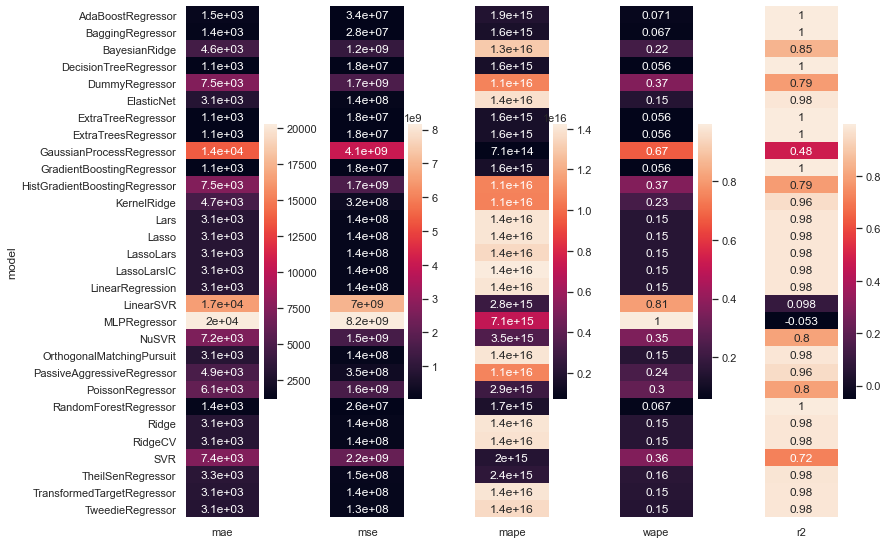

In [10]:
models_scr_heatmap(models_scrs[scrs])

### Performance de cada modelo por tipo de produto

In [11]:
prod_types = ['temporary', 'permanent', 'pasture']
prodtype_models_scrs = []
for scr in sel_scrs:
    prodtype_scr = pd.concat([models_prod_scrs[models_prod_scrs['product_type']==prodtype].set_index('model')[scr] for prodtype in prod_types], 1)
    prodtype_scr.columns = prod_types; prodtype_scr.index.name = scr
    prodtype_models_scrs.append(prodtype_scr)

In [12]:
i=6

wape


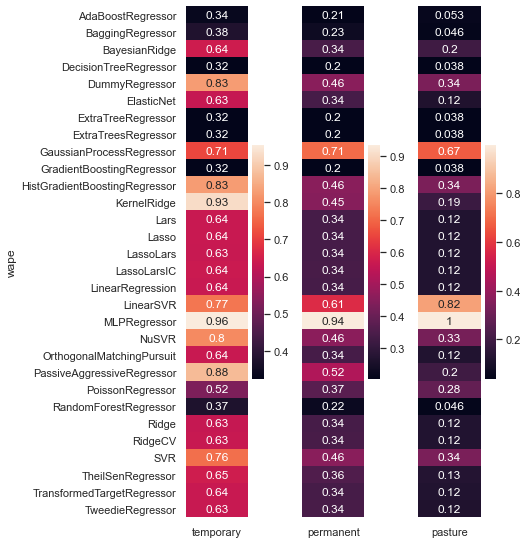

In [13]:
try:
    print(sel_scrs[i+1])
    if i not in range(12): i=-1
except: i=-1
if i==11: i=0
else: i+=1;
models_scr_heatmap(prodtype_models_scrs[i], width=9)

### Performance média final para cada modelo (média da performance para os 3 tipos de produto)

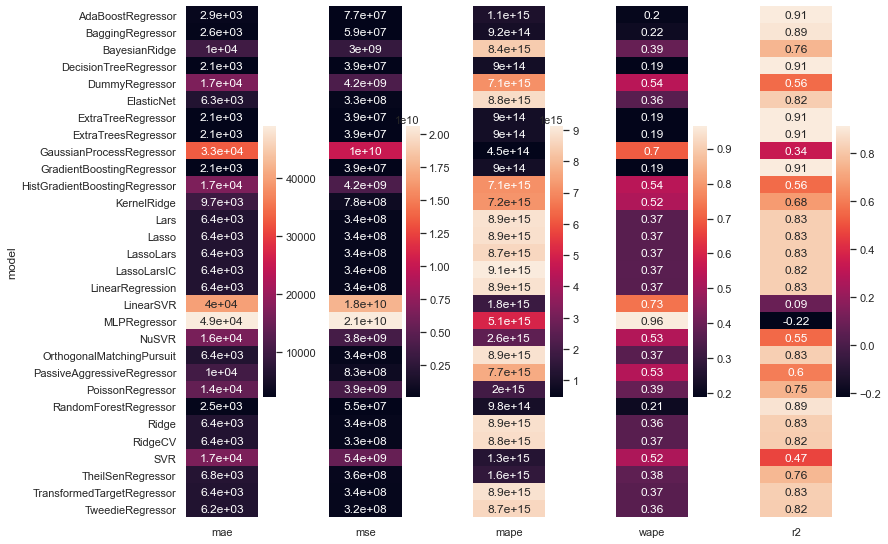

In [14]:
models_prodtype_eval_avgs = models_prod_scrs.groupby(['model', 'product_type']).sum().groupby(['model']).mean()
models_scr_heatmap(models_prodtype_eval_avgs[scrs])

### Loading, processing and scoring specialized models predictions

In [15]:
specialized_models_names = ['Yhat_AutoReg', 'Yhat_arima', 'Yhat_sarimax', 'Yhat_var', 'Yhat_autoarima']
target_years = ['01/01/2016', '01/01/2017']
#Yhat_ext = pd.read_csv('evaluation/predictions/specialized_models_predictions.csv', index_col=0)
#specialized_prediction, ts_specialized_scrs = index_and_score_predictions(series, Yhat_ext, target, target_years)
#specialized_prediction.to_csv('evaluation/predictions/specialized_models_predictions_indexed.csv', index=True)
#ts_specialized_scrs.to_csv('evaluation/scores/scores_timeseries_specialized_models.csv', index=False)

In [16]:
specialized_prediction = pd.read_csv('evaluation/predictions/specialized_models_predictions_indexed.csv', index_col=0)
ts_specialized_scrs = pd.read_csv('evaluation/scores/scores_timeseries_specialized_models.csv')

### Concatening regressors and specialized models scores and predictions

In [17]:
ts_models_scrs_ext = pd.concat([ts_models_scrs, ts_specialized_scrs])
models_prediction_ext = pd.concat([models_prediction, specialized_prediction.loc[models_prediction.index]], 1)

### Selecting models for each time serie by accuracy with multiple metrics

#### Sort models by prediction accuracy for each serie and select best models

In [19]:
pred_by_score = multiple_criteria_predictions(ts_models_scrs_ext, models_prediction_ext, sel_scrs, criteria_map)

Predictions by criteria: 10 - 10


In [20]:
# pred_by_score.to_csv('evaluation/predictions/score_selected_predictions.csv', index=True)

In [23]:
pred_by_score = pd.read_csv('evaluation/predictions/score_selected_predictions.csv', index_col=0)

#### Scores for each criteria prediction

In [104]:
view = 'prodtype'
decision_metric = 'wape'
criteria_scrs, criteria_prod_scrs = score_predictions_df(pred_by_score, Y_e, (prod_indexes if view=='prods' else prodtype_indexes))

In [105]:
[display(criteria_prod_scrs[criteria_prod_scrs['product_type']==prodtype].sort_values(decision_metric).head(3)) for prodtype in (prods if view=='prods' else prodtypes)]

,product_type,mae,mse,mape,wape,r2,model
0,Rice,234.438376,1.430131e+06,0.525812,0.315001,0.620958,e_selected_model
0,Rice,234.438376,1.430131e+06,0.525812,0.315001,0.620958,mae_selected_model
0,Rice,234.438376,1.430131e+06,0.525812,0.315001,0.620958,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
1,Beans,51.930535,21709.054725,0.252566,0.18421,0.901995,e_selected_model
1,Beans,51.930535,21709.054725,0.252566,0.18421,0.901995,mae_selected_model
1,Beans,51.930535,21709.054725,0.252566,0.18421,0.901995,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
2,Cassava,261.316944,540338.876479,0.143973,0.122588,0.955114,e_selected_model
2,Cassava,261.316944,540338.876479,0.143973,0.122588,0.955114,mae_selected_model
2,Cassava,261.316944,540338.876479,0.143973,0.122588,0.955114,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
3,Corn,436.225184,4.378514e+06,0.229439,0.235238,0.673987,e_selected_model
3,Corn,436.225184,4.378514e+06,0.229439,0.235238,0.673987,mae_selected_model
3,Corn,436.225184,4.378514e+06,0.229439,0.235238,0.673987,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
4,Soy,2613.23638,2.697359e+07,0.163635,0.137538,0.967266,e_selected_model
4,Soy,2613.23638,2.697359e+07,0.163635,0.137538,0.967266,mae_selected_model
4,Soy,2613.23638,2.697359e+07,0.163635,0.137538,0.967266,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model


,product_type,mae,mse,mape,wape,r2,model
5,Cocoa,91.378313,38481.157764,0.102024,0.039749,0.998785,e_selected_model
5,Cocoa,91.378313,38481.157764,0.102024,0.039749,0.998785,mae_selected_model
5,Cocoa,91.378313,38481.157764,0.102024,0.039749,0.998785,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
6,Palm oil,671.097153,2.028239e+06,0.152336,0.149702,0.946692,e_selected_model
6,Palm oil,671.097153,2.028239e+06,0.152336,0.149702,0.946692,mae_selected_model
6,Palm oil,671.097153,2.028239e+06,0.152336,0.149702,0.946692,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model


,product_type,mae,mse,mape,wape,r2,model
7,Livestock,1891.420001,1.353879e+07,0.023169,0.013167,0.999671,e_selected_model
7,Livestock,1891.420001,1.353879e+07,0.023169,0.013167,0.999671,mae_selected_model
7,Livestock,1891.420001,1.353879e+07,0.023169,0.013167,0.999671,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
8,Others-temporary,21.444121,7739.094014,2.165691e+15,0.097064,0.995018,e_selected_model
8,Others-temporary,21.444121,7739.094014,2.165691e+15,0.097064,0.995018,mae_selected_model
8,Others-temporary,21.444121,7739.094014,2.165691e+15,0.097064,0.995018,medae_selected_model


,product_type,mae,mse,mape,wape,r2,model
9,Others-permanent,64.845536,41216.983171,1.471673e+14,0.08686,0.984066,e_selected_model
9,Others-permanent,64.845536,41216.983171,1.471673e+14,0.08686,0.984066,mae_selected_model
9,Others-permanent,64.845536,41216.983171,1.471673e+14,0.08686,0.984066,medae_selected_model


[None, None, None, None, None, None, None, None, None, None, None, None]

### Manually structuring custom model prediction

In [97]:
sel_criteria = 'e_selected_model'
Y_hat_final = pred_by_score[sel_criteria].fillna(0).loc[Y_e.index].copy()
final_scrs, final_prodtype_scrs = score_model_predictions(Y_hat_final, Y_e, prodtype_indexes, model_name=sel_criteria)
final_scrs, final_prod_scrs = score_model_predictions(Y_hat_final, Y_e, prod_indexes, model_name=sel_criteria)

In [99]:
final_prodtype_scrs

,product_type,mae,mse,mape,wape,r2
0,temporary,289.963832,2.219982e+06,4.827651e+14,0.164460,0.955685
1,permanent,250.144410,2.536762e+06,6.788683e+13,0.151544,0.873967
2,pasture,1891.420001,1.353879e+07,2.316852e-02,0.013167,0.999671


In [98]:
final_prod_scrs

,product_type,mae,mse,mape,wape,r2
0,Rice,234.438376,1.430131e+06,5.258123e-01,0.315001,0.620958
1,Beans,51.930535,2.170905e+04,2.525660e-01,0.184210,0.901995
2,Cassava,261.316944,5.403389e+05,1.439731e-01,0.122588,0.955114
3,Corn,436.225184,4.378514e+06,2.294389e-01,0.235238,0.673987
4,Soy,2613.236380,2.697359e+07,1.636353e-01,0.137538,0.967266
5,Cocoa,91.378313,3.848116e+04,1.020243e-01,0.039749,0.998785
6,Palm oil,671.097153,2.028239e+06,1.523361e-01,0.149702,0.946692
7,Livestock,1891.420001,1.353879e+07,2.316852e-02,0.013167,0.999671
8,Others-temporary,21.444121,7.739094e+03,2.165691e+15,0.097064,0.995018
9,Others-permanent,64.845536,4.121698e+04,1.471673e+14,0.086860,0.984066


In [29]:
final_wape_scr = final_prod_scrs['wape'].mean(); final_wape_scr

0.10972346222333722

##### Obs: Product types' average WAPE should be 0.109755 for numpy random seed -> 333
##### Obs: Product types' average WAPE should be 0.109723 for numpy random seed -> 25486

### Saving model-serie_key map

In [30]:
key_model_map = top_models_per_ts(ts_models_scrs_ext, criteria='e', criteria_map=criteria_map)
# Saving key-model map
#json.dump(key_model_map, open('models/model_key_map_pos_partial_submission.json', 'w'))

### Submission table

In [31]:
excluded_test_index = pd.read_csv('data/excluded_test_index.csv')['excluded_test_index'].tolist()

In [53]:
prodtype_raw_indexes = tools.category_index.get_ctgrs_indexes(data[data['year'].isin(target_years)].dropna(subset=[target]))
submission = get_submission(
    data, Y_hat_final.copy(), excluded_test_index, prodtype_raw_indexes,
    save=False, path='submission/pos_partial_submission.csv',
    scorers=scorers, scorers_names=scorers_names
)

Nº of predictions: 2191
Submission table lenght: 2226

Final submission WAPE scores:


,wape
product_type,
temporary,0.164515
permanent,0.158442
pasture,0.013167
Final Average,0.112041


#### Reloading submission table

In [113]:
submission = pd.read_csv('submission/partial_submission.csv')

submission['year'] = submission['year'].map(lambda year: '01/01/'+str(year[:4]))
sub = pd.merge(data.reset_index(), submission, on=['year', 'city_code', 'product', 'product_type'], how='right').set_index('index')

In [121]:
sub.sample(5)

,year,city_code,product_type,product,area,destinated_area
index,,,,,,
50017,01/01/2017,93656feaf53efbef,permanent,Others,374.0,490.189984
43443,01/01/2017,77c880feff17c521,temporary,Rice,16000.0,2982.883989
43195,01/01/2017,5b3728d86ce29fd2,temporary,Corn,10.0,10.000000
42982,01/01/2017,6cce2bf873870afc,temporary,Rice,50.0,49.221349
43096,01/01/2017,4b530007d167bd54,temporary,Rice,550.0,500.000000


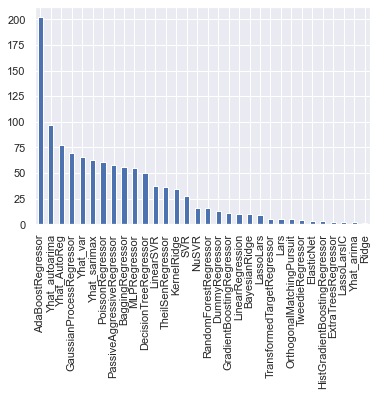

In [189]:
pd.Series(key_model_map).value_counts().plot.bar()

In [ ]:
#### Custom key-model mapping
sel_models = top_models_per_ts(ts_models_scrs, criteria='e', criteria_map)
key_model_map = {}
for key in series.keys():
    if key_prodtype_map[key]=='permanent':
        key_model_map[key] = sel_model
    else:
        key_model_map[key] = sel_models[key]

In [251]:
#### Loading key-model map
key_model_map = json.load(open('models/model_key_map.json', 'r'))

### Defining custom model class

In [252]:
class CustomModel:
    
    def __init__(self, key_regressor_map):
        self.key_map = key_regressor_map
        self.n_keys = len(self.key_map)
        self.ts_models = {}
        for i, key in enumerate(self.key_map.keys()):
            self.ts_models[key] = load_ts_model(key=self.key_map[key]+'_'+key)
            co(wait=True); print(f'Loaded ts models: {i+1}/{self.n_keys}')
        co(wait=True); print(f'Done! Loaded {self.n_keys} ts models.')

    def predict(self, x):
        yhat = []
        for index in x.index:
            key = key_test_index_map[index]
#             row = x.loc[index]
#             key = row['city_code']+'-'+row['product']
#             if row['product']=='Others': key+='-'+row['product_type']
            xe = label_encode(x.loc[[index], ['year']].copy(), base=data)
            yhat.append(self.ts_models[key].predict(xe)[0])
        return pd.Series(yhat, index=x.index)

In [253]:
custom_model = CustomModel(key_model_map)

Done! Loaded 1107 ts models.


In [266]:
xe, ye = get_xy(data_e)
yhat = custom_model.predict(xe)
custom_scrs, custom_prod_scrs = score_model_predictions(yhat, y_e=ye, model_name='CustomModel')

In [268]:
custom_scrs

,mae,mse,mape,wape,r2
CustomModel,20372.334914,8.163259e+09,1.159646e+15,0.999556,-0.053567


In [267]:
custom_prod_scrs

,product_type,mae,mse,mape,wape,r2
0,temporary,1754.798239,5.314900e+07,1.686880e+15,0.995274,-0.060961
1,permanent,1640.814482,2.281455e+07,6.072877e+14,0.994045,-0.133490
2,pasture,143635.675961,6.181724e+10,9.990621e-01,0.999926,-0.500952
